# Hurricane Season Forecasting
Objective: Predict the number of named storms that will occur in a given season based on prevailing conditions in May of that year (the time of year when many hurricane forecasts are released).

In [347]:
import pandas as pd
import numpy as np
from time import process_time, time
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import MultipleLocator

# sklearn model pipelining and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# sklearn models
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.dummy import DummyRegressor

In [348]:
month_of_pred = 5 # 5 = May; 6 = June
train_test_year_split = 2010 # train will include this year; test will start the year after

In [349]:
# Read Number of Storms per year data from hurdat
# TS = Tropical Storms, HU = Hurricanes, TOTAL = total named storms
nstorms = pd.read_csv('data/nstorms_byyear.csv').drop(['Unnamed: 0'], axis=1)
nstorms.head()

,year,TS,HU,TOTAL
0,1950,3,11,14
1,1951,3,8,11
2,1952,2,5,7
3,1953,2,7,9
4,1954,3,6,9


In [350]:
buoy_data = pd.read_csv('data/monthly_buoydata_20240824.csv').drop(['Unnamed: 0'], axis=1).rename(columns={'YY':'year','MM':'month'})
buoy_data = buoy_data[['station_name','year','month','WDIR','WSPD','WVHT','PRES','ATMP','WTMP']]
buoy_data.head()

,station_name,year,month,WDIR,WSPD,WVHT,PRES,ATMP,WTMP
0,"Corpus Christi, TX",2023,1,147.584567,6.681963,1.498904,1017.714138,19.865897,20.871371
1,"Corpus Christi, TX",2023,2,170.765878,6.780516,1.511411,1021.014190,18.835244,20.997623
2,"Corpus Christi, TX",2023,3,119.578815,6.644980,1.560838,1014.904338,21.121627,21.373889
3,"Corpus Christi, TX",2023,4,112.603981,6.751396,1.506480,1015.142761,23.044101,23.354717
4,"Corpus Christi, TX",2023,5,124.815166,4.960036,0.889086,1014.877589,25.980540,26.215419


In [351]:
# Determine earliest date for each station
stations = buoy_data.station_name.unique()

for station in stations:
    tmp_df = buoy_data[buoy_data['station_name'] == station]
    first_year = np.min(tmp_df[['year']])
    print(station + ': ' + str(first_year))

Corpus Christi, TX: 1990
Bay of Campeche: 2005
West Tampa: 1994
Mid Gulf: 1975
Yucatan Basin: 2005
Western Caribbean: 2005
Central Caribbean: 2005
Eastern Caribbean: 2007
North Equatorial One: 2005
North Equatorial Two: 2005
NE St. Martin: 2009
East Bahamas: 2007
NE Bahamas: 2007
South Hatteras: 1975
Canaveral East: 1988


In [352]:
stations = buoy_data.station_name.unique()
# Stations with data going back to 1976:
stations_1976 = ['South Hatteras','Mid Gulf']

df_list = []

for station in stations_1976:
    print(station)
    df = buoy_data[buoy_data['station_name'] == station]
    first_year = np.max([np.min(df[['year']]), 1976])
    first_month_of_first_year = np.min(df[df['year'] == first_year]['month'])
    print(str(first_year) + '-' + str(first_month_of_first_year))
    
    # Create a date range from January 1975 OR first month for which data is available, to December 2023
    start_date = str(first_year)+'-'+str(first_month_of_first_year).zfill(2)
    date_range = pd.date_range(start=start_date, end='2023-12', freq='MS')
    
    # Create a dataframe from the date range
    full_date_df = pd.DataFrame({'date': date_range})
    # Extract year and month from the date
    full_date_df['year'] = full_date_df['date'].dt.year
    full_date_df['month'] = full_date_df['date'].dt.month
    # Drop the date column as it's no longer needed
    full_date_df.drop(columns='date', inplace=True)
    #print(full_date_df.head())

    full_date_df['station_name'] = station
    
    merged_df = pd.merge(full_date_df, df, on=['station_name', 'year', 'month'], how='left')
    print(merged_df[merged_df['year']==1976])
    
    ## Key assumption here, using forward then backward filling to fill in missing values.
    ## Instead, forward fill 
    #     based on the last value for that month (i.e. fill a missing May 2007 with May 2006)
    # merged_df = merged_df.ffill().bfill()
    
    # First, sort the DataFrame by 'station_name', 'month', and 'year'
    merged_df = merged_df.sort_values(by=['station_name', 'month', 'year'])
    
    # Now, group by 'station_name' and 'month', and then apply forward fill followed by backward fill
    merged_df = merged_df.groupby(['station_name', 'month']).apply(lambda group: group.ffill().bfill()).reset_index(drop=True)

    merged_df = merged_df.sort_values(by = ['station_name','year','month'])
    print(merged_df[merged_df['year'] == 1976])
    
    # Rename columns not named 'year' or 'month'
    station_nospace = station.replace(" ", "")+"_"
    df2 = merged_df.rename(columns=lambda x: f"{station_nospace}{x}" if x not in ['year', 'month', 'station_name'] else x, inplace=False)
    df2 = df2.drop(['station_name'], axis=1)

    df_list.append(df2)

buoy_data_wide = df_list[0]
# Iterate over the remaining DataFrames and merge them into the wide DataFrame
for df in df_list[1:]:
    buoy_data_wide = pd.merge(buoy_data_wide, df, on=['year', 'month'], how='outer')

buoy_data_may = buoy_data_wide[buoy_data_wide['month']==month_of_pred].reset_index(drop=True)
#buoy_data_may = buoy_data_may.ffill().bfill()
print(buoy_data_wide[buoy_data_wide['year']==1976])

South Hatteras
1976-1
    year  month    station_name        WDIR       WSPD      WVHT         PRES  \
0   1976      1  South Hatteras  202.593466   9.580978       NaN  1052.953971   
1   1976      2  South Hatteras  189.000000   9.422047  2.121514  1091.224803   
2   1976      3  South Hatteras  276.000000   7.517490  1.517939  1020.813308   
3   1976      4  South Hatteras         NaN   6.955039  1.344788  1088.059846   
4   1976      5  South Hatteras  174.836066   7.820902       NaN  1017.281070   
5   1976      6  South Hatteras  171.898734   5.824153  0.991279  1018.547679   
6   1976      7  South Hatteras  210.500000   6.560759  1.022128  1017.839662   
7   1976      8  South Hatteras  137.346939   6.416549  1.650543  1017.315141   
8   1976      9  South Hatteras  135.156250   6.062397  0.800000  1016.581405   
9   1976     10  South Hatteras  149.781746   7.932411  1.519592  1016.024506   
10  1976     11  South Hatteras  222.984293   8.451562  1.589130  1940.562617   
11  19

In [353]:
# Ocean Nino Index Data

oni = pd.read_csv('data/Monthly_Nino_3.4_Index.csv')
oni = oni.sort_values(['year','month'])
oni['ONI_anom_change'] = oni['ONI_anom'].diff()
oni.loc[0,'ONI_anom_change'] = 0

# Note that we filter to the month of May here:
oni2 = oni[oni['month']==month_of_pred].drop(['Unnamed: 0','month','ONI_climAdjust','ONI_total'],axis=1).set_index('year')
oni2.head()

,ONI_anom,ONI_anom_change
year,,
1950,-1.37,0.00
1951,0.37,0.17
1952,0.23,-0.19
1953,0.71,0.07
1954,-0.45,0.29


In [354]:
df = pd.merge(nstorms[nstorms['year']>= 1976], buoy_data_may, left_on = 'year', right_on = 'year', how = 'inner').set_index('year')
df = df.drop(['month'],axis=1)
df = pd.merge(df, oni2, left_on = 'year', right_on = 'year', how = 'left')
df.head()

,TS,HU,TOTAL,SouthHatteras_WDIR,SouthHatteras_WSPD,SouthHatteras_WVHT,SouthHatteras_PRES,SouthHatteras_ATMP,SouthHatteras_WTMP,MidGulf_WDIR,MidGulf_WSPD,MidGulf_WVHT,MidGulf_PRES,MidGulf_ATMP,MidGulf_WTMP,ONI_anom,ONI_anom_change
year,,,,,,,,,,,,,,,,,
1976,2,6,8,174.836066,7.820902,1.046774,1017.281070,21.195082,22.142798,126.619048,5.714488,0.889695,1043.881690,23.702120,25.060071,-0.31,0.22
1977,1,5,6,191.100402,5.914800,1.046774,1016.840000,21.525600,23.178313,145.346154,4.367308,1.204286,1015.015385,25.011538,25.721154,0.22,0.19
1978,6,5,11,182.210526,6.320974,1.259184,1017.174157,21.523970,23.256180,137.108871,4.766532,1.035593,1013.395181,25.568675,25.269697,-0.31,-0.01
1979,3,5,8,182.451923,6.328415,1.259184,1152.858992,21.932455,22.586250,130.362903,6.003629,1.189069,1014.309677,25.319355,25.599588,0.19,-0.23
1980,2,9,11,190.704301,5.840726,1.271640,1014.444489,22.034677,23.021909,138.636119,5.668414,0.920699,1012.922849,25.641667,25.988844,0.51,0.17


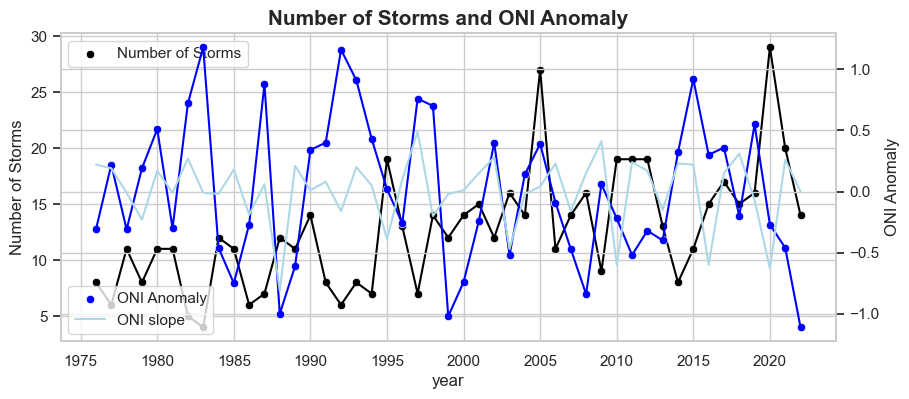

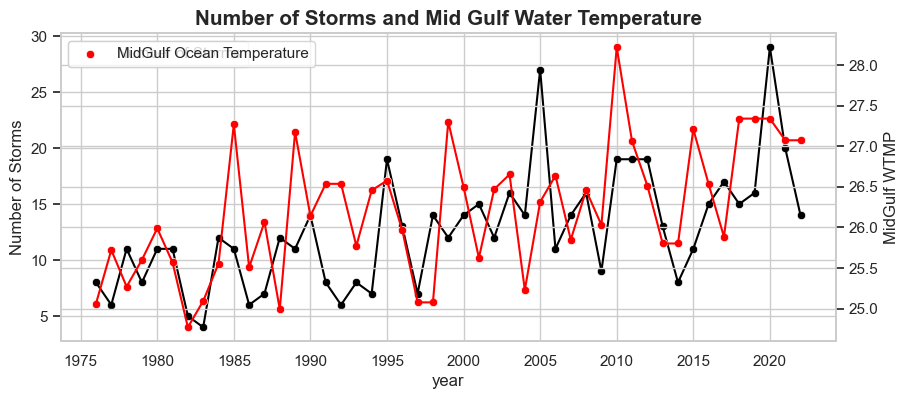

In [355]:
## Plotting the Key Features and Target Variable: ONI Anomaly
#fig, ax = plt.subplots(2, 1, figsize=(10, 8)) 
plt.figure(figsize=(10, 4))
sns.set(style = 'whitegrid')

# Plot the actual values
sns.scatterplot(data=df, x='year', y='TOTAL', color='black', label='Number of Storms')
sns.lineplot(data=df, x='year', y='TOTAL', color='black')
plt.ylabel('Number of Storms')

ax2 = plt.twinx()
sns.scatterplot(data = df, x='year', y='ONI_anom', color = 'blue', label = 'ONI Anomaly', ax = ax2)
sns.lineplot(data = df, x='year', y ='ONI_anom', color = 'blue', ax=ax2)
sns.lineplot(data = df, x = 'year', y = 'ONI_anom_change', color = 'lightblue', ax = ax2, label = 'ONI slope')
plt.ylabel('ONI Anomaly')

# Add labels and title
plt.xlabel('Year')
plt.title('Number of Storms and ONI Anomaly', weight = 'bold', size = 15)
plt.legend()

# Customize the ticks and gridlines
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.savefig('figures/EDA_NumStorms_and_ONI.png')
plt.show()

## Now plot MidGulf Temperature:
#fig, ax = plt.subplots(2, 1, figsize=(10, 8)) 
plt.figure(figsize=(10, 4))
sns.set(style = 'whitegrid')

# Plot the actual values
sns.scatterplot(data=df, x='year', y='TOTAL', color='black', label='Number of Storms')
sns.lineplot(data=df, x='year', y='TOTAL', color='black')
plt.ylabel('Number of Storms')

ax2 = plt.twinx()
sns.scatterplot(data = df, x='year', y='MidGulf_WTMP', color = 'red', label = 'MidGulf Ocean Temperature', ax = ax2)
sns.lineplot(data = df, x='year', y ='MidGulf_WTMP', color = 'red', ax=ax2)
plt.ylabel('MidGulf WTMP')

# Add labels and title
plt.xlabel('Year')
plt.title('Number of Storms and Mid Gulf Water Temperature', weight = 'bold', size = 15)
plt.legend()

# Customize the ticks and gridlines
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.savefig('figures/EDA_NumStorms_and_MidGulfWTMP.png')
plt.show()

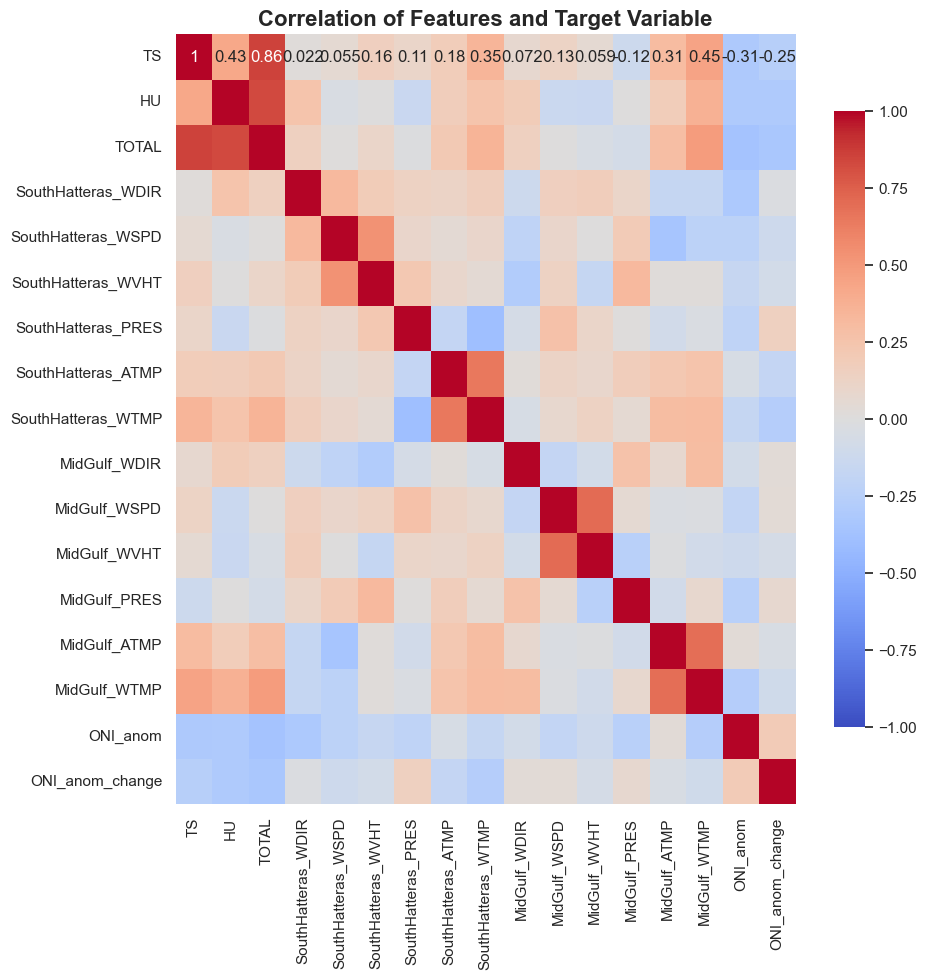

In [356]:
## Correlation
corr_matrix = df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, cbar_kws={"shrink": .8})
plt.title('Correlation of Features and Target Variable', weight = 'bold', size = 16)
plt.savefig('figures/EDA_FeatureCorrelation')
plt.show()

In [357]:
## Define X and y from df:
unused_cols = ['TS','HU']
df_nona = df.drop(unused_cols, axis=1).dropna()
X = df_nona.drop(['TOTAL'], axis=1)
y = df_nona['TOTAL']

X.head()

,SouthHatteras_WDIR,SouthHatteras_WSPD,SouthHatteras_WVHT,SouthHatteras_PRES,SouthHatteras_ATMP,SouthHatteras_WTMP,MidGulf_WDIR,MidGulf_WSPD,MidGulf_WVHT,MidGulf_PRES,MidGulf_ATMP,MidGulf_WTMP,ONI_anom,ONI_anom_change
year,,,,,,,,,,,,,,
1976,174.836066,7.820902,1.046774,1017.281070,21.195082,22.142798,126.619048,5.714488,0.889695,1043.881690,23.702120,25.060071,-0.31,0.22
1977,191.100402,5.914800,1.046774,1016.840000,21.525600,23.178313,145.346154,4.367308,1.204286,1015.015385,25.011538,25.721154,0.22,0.19
1978,182.210526,6.320974,1.259184,1017.174157,21.523970,23.256180,137.108871,4.766532,1.035593,1013.395181,25.568675,25.269697,-0.31,-0.01
1979,182.451923,6.328415,1.259184,1152.858992,21.932455,22.586250,130.362903,6.003629,1.189069,1014.309677,25.319355,25.599588,0.19,-0.23
1980,190.704301,5.840726,1.271640,1014.444489,22.034677,23.021909,138.636119,5.668414,0.920699,1012.922849,25.641667,25.988844,0.51,0.17


## Initial Modeling, using default hyperparameters, training on ALL data

In [358]:
lr = LinearRegression().fit(X, y)
preds = lr.predict(X)

pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])
pipe_lasso.fit(X,y)
preds_lasso = pipe_lasso.predict(X)

pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])
pipe_ridge.fit(X,y)
preds_ridge = pipe_ridge.predict(X)

In [359]:
y_preds = df_nona[['TOTAL']].copy().reset_index().rename(columns = {'TOTAL':'actual'})
baseline = np.mean(y_preds['actual'])
y_preds['baseline'] = baseline
y_preds['predicted'] = preds
y_preds['lasso'] = preds_lasso
y_preds['ridge'] = preds_ridge
y_preds.head()

,year,actual,baseline,predicted,lasso,ridge
0,1976,8,12.638298,7.859985,10.202339,7.835651
1,1977,6,12.638298,8.099887,11.237401,8.385841
2,1978,11,12.638298,9.831202,11.170547,10.028927
3,1979,8,12.638298,9.710639,11.562169,9.834203
4,1980,11,12.638298,11.862032,11.480825,11.766955


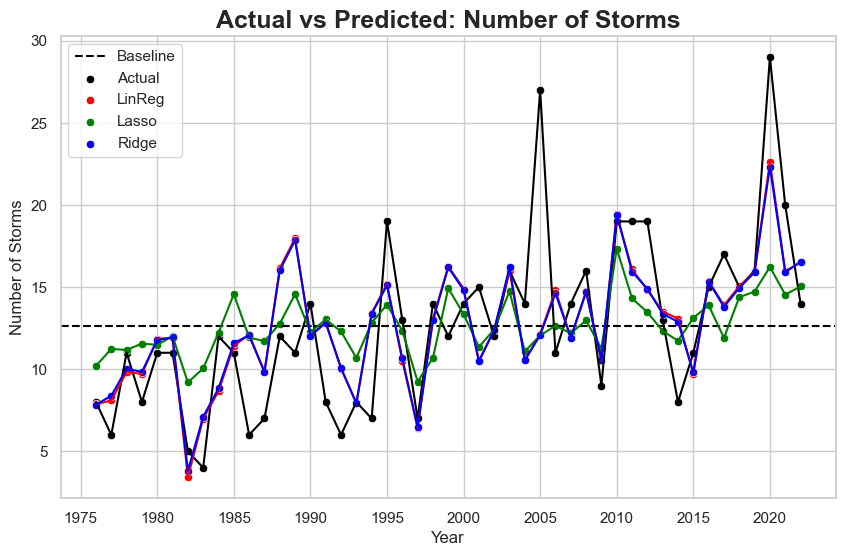

In [360]:
plt.figure(figsize=(10, 6))
plt.axhline(y=baseline, color='black', linestyle='--', label='Baseline')
sns.set(style = 'whitegrid')

# Plot the actual values
sns.scatterplot(data=y_preds, x='year', y='actual', color='black', label='Actual')
sns.lineplot(data=y_preds, x='year', y='actual', color='black')

# Plot the predicted values
sns.scatterplot(data=y_preds, x='year', y='predicted', color='red', label='LinReg')
sns.lineplot(data=y_preds, x='year', y='predicted', color='red')

# Plot the predicted values - Lasso
sns.scatterplot(data=y_preds, x='year', y='lasso', color='green', label='Lasso')
sns.lineplot(data=y_preds, x='year', y='lasso', color='green')

# Plot the predicted values - Ridge
sns.scatterplot(data=y_preds, x='year', y='ridge', color='blue', label='Ridge')
sns.lineplot(data=y_preds, x='year', y='ridge', color='blue')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.title('Actual vs Predicted: Number of Storms', weight = 'bold', size = 18)
plt.legend()

# Customize the ticks and gridlines
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.show()

Note: I expect that these (particularly the LinReg and barely-regularized Ridge analysis) are way overfit and would not do well on new data. This is a major challenge for this problem -- given the limited number of samples due to good data only going back 50 or so years, it may be difficult to create a predictive model that doesn't overfit.

#### Mean Squared Error

In [361]:
mse_baseline = mean_squared_error(y_preds['actual'],y_preds['baseline'])
print(mse_baseline)

27.08193752829335


In [362]:
mse_lr = mean_squared_error(y_preds['actual'],y_preds['predicted'])
print(mse_lr)

14.292423998703224


In [363]:
mse_lasso = mean_squared_error(y_preds['actual'],y_preds['lasso'])
print(mse_lasso)

19.33257803972814


# Same models with GridSearchCV and a Test/Train split:
- Train Test split with data before 2009 as train data, 2009 on used as test data
- Scaling with StandardScaler()
- Grid search for best hyperparameters for Lasso and Ridge (alpha term that controls amount of regularization)

Introduce a new "y" to train on: *Accumulated Cyclone Energy (ACE)*, which accounts for storm duration and strength (stronger, longer duration storms count more toward ACE). In some ways ACE is a better measure of hurricane activity, and perhaps it will be easier to predict than the simple storm count.

In [364]:
ace0 = pd.read_csv('data/ace-north-atlantic-hurricanes.csv')
ace = ace0[['Year','Acumulated cyclone energy index']].rename(columns={'Acumulated cyclone energy index':'ACE','Year':'year'}).set_index('year')
y_wACE = pd.merge(y, ace, on='year')
y_wACE = y_wACE.rename(columns={'TOTAL':'NumStorms'})

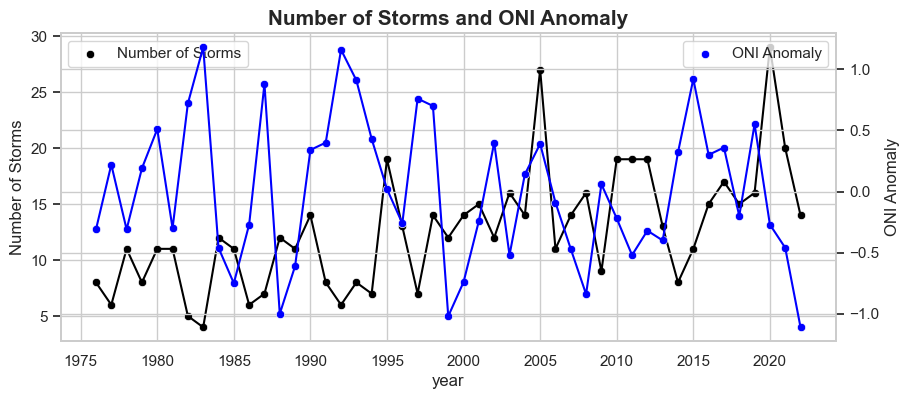

In [365]:
## Plotting the Number of Storms and ACE
#fig, ax = plt.subplots(2, 1, figsize=(10, 8)) 
plt.figure(figsize=(10, 4))
sns.set(style = 'whitegrid')

# Plot the actual values
sns.scatterplot(data=y_wACE, x='year', y='NumStorms', color='black', label='Number of Storms')
sns.lineplot(data=y_wACE, x='year', y='NumStorms', color='black')
plt.ylabel('Number of Storms')

ax2 = plt.twinx()
sns.scatterplot(data = df, x='year', y='ONI_anom', color = 'blue', label = 'ONI Anomaly', ax = ax2)
sns.lineplot(data = df, x='year', y ='ONI_anom', color = 'blue', ax=ax2)
plt.ylabel('ONI Anomaly')

# Add labels and title
plt.xlabel('Year')
plt.title('Number of Storms and ONI Anomaly', weight = 'bold', size = 15)
plt.legend()

# Customize the ticks and gridlines
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.savefig('figures/EDA_NumStorms_and_ONI.png')
plt.show()

In [366]:
X_train = X[X.index <= train_test_year_split]
X_test = X[X.index > train_test_year_split]
y_df_train = y_wACE[y_wACE.index <= train_test_year_split]
y_df_test = y_wACE[y_wACE.index > train_test_year_split]

# BEFORE TRAINING YOU NEED TO SPECIFY which column to train on; NumStorms or ACE
# See arg ACE = True/False in run_grid function
print(y_df_train.head())

      NumStorms  ACE
year                
1976          8   84
1977          6   25
1978         11   63
1979          8   93
1980         11  149


In [367]:
def run_grid(X_train, X_test, y_df_train, y_df_test, model_setup, ACE = False, N_JOBS = 1, N_CV = 5, features_filter = None):
    if ACE:
        y_train = y_df_train['ACE']
        y_test = y_df_test['ACE']
    else:
        y_train = y_df_train['NumStorms']
        y_test = y_df_test['NumStorms']

    if features_filter is not None:
        X_train = X_train[features_filter]
        X_test = X_test[features_filter]
        print('Filtering features')

    start_time = time()
    
    # Make Pipeline
    pipe = Pipeline([
        #('preprocessor',preprocessor),
        ('poly', PolynomialFeatures()),
        ('scaler',StandardScaler()),
        (model_setup.get('name'), model_setup.get('model'))
        ])

    # Fit Grid on all params
    grid = GridSearchCV(estimator = pipe,
                        param_grid = model_setup.get('param_dict'),
                       cv = N_CV,
                       n_jobs = N_JOBS)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_train_preds = best_model.predict(X_train)
    y_test_preds = best_model.predict(X_test)

    # Save stuff to a dataframe (best params, fit time, scores)
    res_dict = {'model': [model_setup.get('name')],
                'best_params': [grid.best_params_],
                'best_score': [grid.best_score_],
                'fit time': [grid.refit_time_],
               'train r2': [grid.score(X_train, y_train)],
               'test r2': [grid.score(X_test, y_test)],
                'train mse': [mean_squared_error(y_train, y_train_preds)],
                'test mse': [mean_squared_error(y_test, y_test_preds)]
               }
    res_df = pd.DataFrame(res_dict)

    feature_names = best_model.named_steps['poly'].get_feature_names_out()
    if model_setup.get('name') != 'dummy':
        coefs = best_model.named_steps[model_setup.get('name')].coef_
        coef_df = pd.DataFrame({'feature':feature_names, 'coef':coefs})
    else:
        coef_df = pd.DataFrame()

    end_time = time()
    print(f"Elapsed time: {end_time - start_time} seconds")
    
    return(res_df, best_model, coef_df)

In [368]:
X_train.head()

,SouthHatteras_WDIR,SouthHatteras_WSPD,SouthHatteras_WVHT,SouthHatteras_PRES,SouthHatteras_ATMP,SouthHatteras_WTMP,MidGulf_WDIR,MidGulf_WSPD,MidGulf_WVHT,MidGulf_PRES,MidGulf_ATMP,MidGulf_WTMP,ONI_anom,ONI_anom_change
year,,,,,,,,,,,,,,
1976,174.836066,7.820902,1.046774,1017.281070,21.195082,22.142798,126.619048,5.714488,0.889695,1043.881690,23.702120,25.060071,-0.31,0.22
1977,191.100402,5.914800,1.046774,1016.840000,21.525600,23.178313,145.346154,4.367308,1.204286,1015.015385,25.011538,25.721154,0.22,0.19
1978,182.210526,6.320974,1.259184,1017.174157,21.523970,23.256180,137.108871,4.766532,1.035593,1013.395181,25.568675,25.269697,-0.31,-0.01
1979,182.451923,6.328415,1.259184,1152.858992,21.932455,22.586250,130.362903,6.003629,1.189069,1014.309677,25.319355,25.599588,0.19,-0.23
1980,190.704301,5.840726,1.271640,1014.444489,22.034677,23.021909,138.636119,5.668414,0.920699,1012.922849,25.641667,25.988844,0.51,0.17


In [414]:
model_setup_linreg = {
    'name':'linreg',
    'param_dict':{'poly__degree':[1,2,3,4,5,6]},
    'model': LinearRegression()
}
results_linreg, best_linreg, _ = run_grid(X_train, X_test, y_df_train, y_df_test,
                                          model_setup_linreg, N_JOBS = 2)
results_linreg

Elapsed time: 0.47980594635009766 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,linreg,{'poly__degree': 1},-10.559004,0.002801,0.456932,-2.557211,11.577757,90.906493


In [418]:
model_setup_linreg_selectfeatures = {
    'name':'linreg_selectfeatures',
    'param_dict':{'poly__degree':[1,2,3,4,5,6]},
    'model': LinearRegression()
}
linreg_features_filter = ['SouthHatteras_WTMP','MidGulf_WTMP','ONI_anom','ONI_anom_change']
results_linreg_selectfeatures, best_linreg_selectfeatures, _ = run_grid(X_train, X_test, y_df_train, y_df_test,
                                          model_setup_linreg_selectfeatures, N_JOBS = 2,
                                         features_filter = linreg_features_filter)
results_linreg_selectfeatures

Filtering features
Elapsed time: 0.11719322204589844 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,linreg_selectfeatures,{'poly__degree': 1},-0.747373,0.003221,0.293611,-0.591971,15.059639,40.683704


In [416]:
# Training Basic Linear Regression on ACE:
results_linreg_ACE, best_linreg_ACE, _ = run_grid(X_train, X_test, y_df_train, y_df_test,
                                                  model_setup_linreg, ACE = True, N_JOBS = 2)
results_linreg_ACE

Elapsed time: 0.3251667022705078 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,linreg,{'poly__degree': 1},-6.795307,0.00149,0.512309,-4.492315,1903.724263,13464.257073


In [417]:
# Training Linear Regression w/ Select Features on ACE:
results_linreg_selectfeatures_ACE, best_linreg_selectfeatures_ACE, _ = run_grid(X_train, X_test, y_df_train, y_df_test,
                                                  model_setup_linreg_selectfeatures, ACE = True, N_JOBS = 2,
                                         features_filter = linreg_features_filter)
results_linreg_selectfeatures_ACE

Filtering features
Elapsed time: 0.05064272880554199 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,linreg_selectfeatures,{'poly__degree': 1},-0.613262,0.00126,0.233359,-0.232599,2992.620959,3021.681461


In [371]:
model_setup_lasso = {
    'name':'lasso',
    'param_dict':{'poly__degree':[1,2,3,4,6],
                  'lasso__alpha':[0.1,0.5,1,2,5,10,15],
                  'lasso__max_iter':[1000000],
                  'lasso__random_state':[42,43]},
    'model': Lasso()
}
results_lasso, best_lasso, coefs_lasso = run_grid(X_train, X_test, y_df_train, y_df_test,
                                                  model_setup_lasso, N_JOBS = 2)
results_lasso

Elapsed time: 12.933498859405518 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,lasso,"{'lasso__alpha': 1, 'lasso__max_iter': 1000000...",-0.769902,0.002387,0.177277,-0.562434,17.539788,39.928859


In [386]:
# Training Lasso on ACE:
model_setup_lasso = {
    'name':'lasso',
    'param_dict':{'poly__degree':[1,2,3,4,5],
                  'lasso__alpha':[1,5,10,15,25],
                  'lasso__max_iter':[750000],
                  'lasso__random_state':[42,43]},
    'model': Lasso()
}
results_lasso_ACE, best_lasso_ACE, _ = run_grid(X_train, X_test, y_df_train, y_df_test,
                                                model_setup_lasso, ACE = True, N_JOBS = 2)
results_lasso_ACE

Elapsed time: 7.453283071517944 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,lasso,"{'lasso__alpha': 15, 'lasso__max_iter': 750000...",-0.474283,0.053762,0.166517,-0.005781,3253.539735,2465.643545


In [373]:
model_setup_ridge = {
    'name':'ridge',
    'param_dict':{'poly__degree':[1,2,3,4,5,6],
                  'ridge__random_state':[42,43],
                  'ridge__alpha':[0.0001,0.001,0.01,0.1,1,5,10,20,40,60,100,200,1000]},
    'model': Ridge()
}
results_ridge, best_ridge, coefs_ridge = run_grid(X_train, X_test, y_df_train, y_df_test,
                                                  model_setup_ridge, N_JOBS = 2)
results_ridge

Elapsed time: 2.0715088844299316 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,ridge,"{'poly__degree': 1, 'ridge__alpha': 40, 'ridge...",-0.660672,0.001198,0.278499,-0.504207,15.381812,38.440844


In [374]:
# Training Ridge Regression Model on ACE:
results_ridge_ACE, best_ridge_ACE, _ = run_grid(X_train, X_test, y_df_train, y_df_test,
                                                model_setup_ridge, ACE = True, N_JOBS = 2)
results_ridge_ACE

Elapsed time: 2.0255298614501953 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,ridge,"{'poly__degree': 1, 'ridge__alpha': 40, 'ridge...",-0.310461,0.001982,0.265831,0.111726,2865.863894,2177.579328


In [375]:
model_setup_dummy = {
    'name':'dummy',
    'param_dict':{'poly__degree':[1],
                  'dummy__strategy':['mean']},
    'model':DummyRegressor()
}
results_dummy, best_dummy, coefs_dummy = run_grid(X_train, X_test, y_df_train, y_df_test,
                                                  model_setup_dummy, N_JOBS = 2)
results_dummy

Elapsed time: 0.011524200439453125 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,dummy,"{'dummy__strategy': 'mean', 'poly__degree': 1}",-0.940412,0.000833,0.0,-0.963411,21.319184,50.176054


In [376]:
results_dummy_ACE, best_dummy_ACE, coefs_dummy_ACE = run_grid(X_train, X_test, y_df_train, y_df_test,
                                                              model_setup_dummy, ACE = True, N_JOBS = 2)
results_dummy_ACE

Elapsed time: 0.01626276969909668 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,dummy,"{'dummy__strategy': 'mean', 'poly__degree': 1}",-0.466993,0.001129,0.0,-0.159843,3903.547755,2843.323673


In [377]:
# Ignore these warnings from seaborn:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

   year  actual  ACE  ACE_per_storm   baseline     linreg      lasso  \
0  1976       8   84      10.500000  12.638298   8.462683  10.612068   
1  1977       6   25       4.166667  12.638298   7.042793  10.741745   
2  1978      11   63       5.727273  12.638298   9.163314  11.081122   
3  1979       8   93      11.625000  12.638298  11.877118  11.241288   
4  1980      11  149      13.545455  12.638298   9.840507  10.746673   

       ridge  
0   9.217894  
1   9.903094  
2  10.651324  
3  11.112170  
4  10.600614  


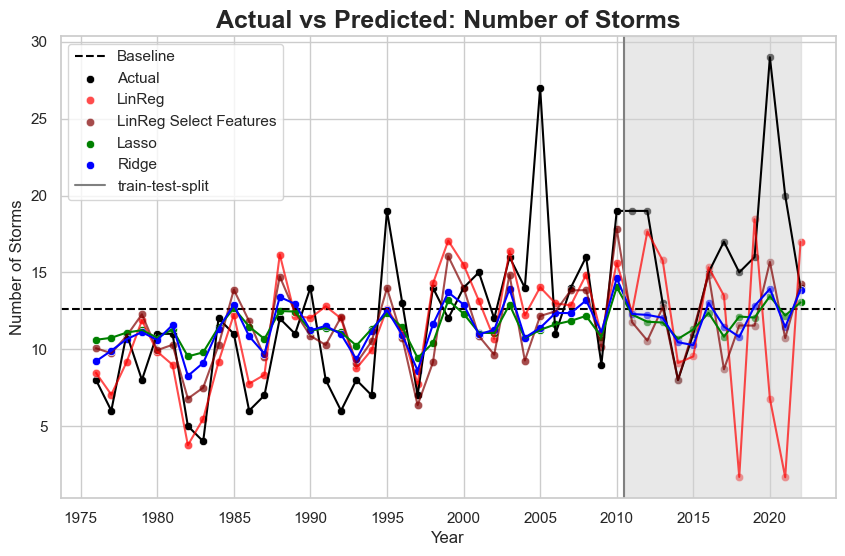

In [401]:
preds_linreg = best_linreg.predict(X)
preds_linreg_selectfeatures = best_linreg_selectfeatures.predict(X[linreg_features_filter])
preds_ridge = best_ridge.predict(X)
preds_lasso = best_lasso.predict(X)

y_preds_gridsearch = pd.DataFrame(y_wACE).rename(columns={'NumStorms':'actual'})
baseline = np.mean(y_preds_gridsearch['actual'])
y_preds_gridsearch['baseline'] = baseline
y_preds_gridsearch['linreg'] = preds_linreg
y_preds_gridsearch['lasso'] = preds_lasso
y_preds_gridsearch['ridge'] = preds_ridge
y_preds_gridsearch.reset_index(inplace=True)
y_preds_gridsearch = y_preds_gridsearch.clip(lower=0)
print(y_preds_gridsearch.head())

plt.figure(figsize=(10, 6))
plt.axhline(y=baseline, color='black', linestyle='--', label='Baseline')
sns.set(style = 'whitegrid')

# Plot the actual values
sns.scatterplot(data=y_preds_gridsearch, x='year', y='actual', color='black', label='Actual')
sns.lineplot(data=y_preds_gridsearch, x='year', y='actual', color='black')

# Plot the predicted values
sns.scatterplot(data=y_preds_gridsearch, x='year', y='linreg', color='red', label='LinReg', alpha = 0.7)
sns.lineplot(data=y_preds_gridsearch, x='year', y='linreg', color='red', alpha = 0.7)

# Plot the predicted values - Linear Regression with Select Features
sns.scatterplot(data=y_preds_gridsearch_ACE, x='year', y='linreg_selectfeatures', color='maroon', label='LinReg Select Features', alpha = 0.7)
sns.lineplot(data=y_preds_gridsearch_ACE, x='year', y='linreg_selectfeatures', color='maroon',alpha = 0.7)

# Plot the predicted values - Lasso
sns.scatterplot(data=y_preds_gridsearch, x='year', y='lasso', color='green', label='Lasso')
sns.lineplot(data=y_preds_gridsearch, x='year', y='lasso', color='green')

# Plot the predicted values - Ridge
sns.scatterplot(data=y_preds_gridsearch, x='year', y='ridge', color='blue', label='Ridge')
sns.lineplot(data=y_preds_gridsearch, x='year', y='ridge', color='blue')

plt.axvline(x=train_test_year_split+0.5, color='gray', linestyle='-', label='train-test-split')
plt.axvspan(train_test_year_split+0.5, np.max(y_preds_gridsearch['year'].astype(int)), color='lightgray', alpha=0.5)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.title('Actual vs Predicted: Number of Storms', weight = 'bold', size = 18)
plt.legend()

# Customize the ticks and gridlines
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.savefig('figures/actual_v_predicted_numstorms.png')
plt.show()

   year  actual    baseline      linreg  linreg_selectfeatures       lasso  \
0  1976      84  107.425532  104.494922              81.749222   90.929899   
1  1977      25  107.425532   21.937672              80.901133   94.442776   
2  1978      63  107.425532   77.528304              97.792019   99.358366   
3  1979      93  107.425532  128.070634             113.246830  107.490140   
4  1980     149  107.425532  102.511950              82.168248   96.517866   

        ridge  
0   79.640738  
1   84.263539  
2   96.079964  
3  102.896962  
4   96.767608  


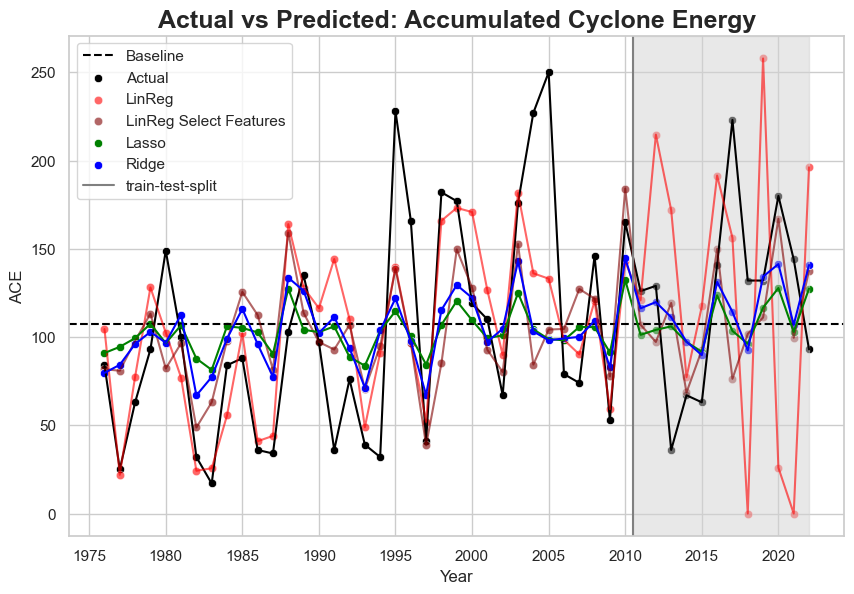

In [403]:
preds_linreg = best_linreg_ACE.predict(X)
preds_linreg_selectfeatures = best_linreg_selectfeatures_ACE.predict(X[linreg_features_filter])
preds_ridge = best_ridge_ACE.predict(X)
preds_lasso = best_lasso_ACE.predict(X)

y_preds_gridsearch_ACE = y_wACE[['ACE']].rename(columns={'ACE':'actual'})
baseline = np.mean(y_preds_gridsearch_ACE['actual'])
y_preds_gridsearch_ACE['baseline'] = baseline
y_preds_gridsearch_ACE['linreg'] = preds_linreg
y_preds_gridsearch_ACE['linreg_selectfeatures'] = preds_linreg_selectfeatures
y_preds_gridsearch_ACE['lasso'] = preds_lasso
y_preds_gridsearch_ACE['ridge'] = preds_ridge
y_preds_gridsearch_ACE.reset_index(inplace=True)
y_preds_gridsearch_ACE = y_preds_gridsearch_ACE.clip(lower=0)
print(y_preds_gridsearch_ACE.head())

plt.figure(figsize=(10, 6.5))
plt.axhline(y=baseline, color='black', linestyle='--', label='Baseline')
sns.set(style='whitegrid')

# Plot the actual values
sns.scatterplot(data=y_preds_gridsearch_ACE, x='year', y='actual', color='black', label='Actual')
sns.lineplot(data=y_preds_gridsearch_ACE, x='year', y='actual', color='black')

# Plot the predicted values - Linear Regression with no Regularization
sns.scatterplot(data=y_preds_gridsearch_ACE, x='year', y='linreg', color='red', label='LinReg', alpha = 0.6)
sns.lineplot(data=y_preds_gridsearch_ACE, x='year', y='linreg', color='red',alpha = 0.6)

# Plot the predicted values - Linear Regression with Select Features
sns.scatterplot(data=y_preds_gridsearch_ACE, x='year', y='linreg_selectfeatures', color='maroon', label='LinReg Select Features', alpha = 0.6)
sns.lineplot(data=y_preds_gridsearch_ACE, x='year', y='linreg_selectfeatures', color='maroon',alpha = 0.6)

# Plot the predicted values - Lasso
sns.scatterplot(data=y_preds_gridsearch_ACE, x='year', y='lasso', color='green', label='Lasso')
sns.lineplot(data=y_preds_gridsearch_ACE, x='year', y='lasso', color='green')

# Plot the predicted values - Ridge
sns.scatterplot(data=y_preds_gridsearch_ACE, x='year', y='ridge', color='blue', label='Ridge')
sns.lineplot(data=y_preds_gridsearch_ACE, x='year', y='ridge', color='blue')

plt.axvline(x=train_test_year_split+0.5, color='gray', linestyle='-', label='train-test-split')
plt.axvspan(train_test_year_split+0.5, np.max(y_preds_gridsearch_ACE['year'].astype(int)), color='lightgray', alpha=0.5)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('ACE')
plt.title('Actual vs Predicted: Accumulated Cyclone Energy', weight = 'bold', size = 18)
plt.legend()

# Customize the ticks and gridlines
from matplotlib.ticker import MultipleLocator
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.savefig('figures/actual_v_predicted_ACE.png')
plt.show()

# Discussion of Results
Take a look at the test r2 for lasso and ridge regression above. We have no confidence that this model is working correctly (r^2 < 0!!).

Because of this outcome, I've decided to do a different type of forecast: using monthly atmospheric/climatological data to forecast number of storms in that month. This effectively 12x the available data since we can use monthly rather than only May data.

### Were the models better at predicting Number of Storms or ACE?

Hypothesis: The models will be better at predicting Accumulated Cyclone Energy (ACE) than Number of Storms. In other words, I am hypothesizing that the data we are using (El Nino index and sea surface temperature data) will better predict the overall strength and duration of storms in a season (since sea surface temperatures are known to drive and sustain hurricanes) than number of storms (which is a smaller, more discrete, perhaps more random number to predict, and influenced by many factors beyond sea surface temperatures.

In [419]:
results_nstorms = pd.concat([results_linreg, results_linreg_selectfeatures,
                             results_lasso, results_ridge, results_dummy], ignore_index = True)
results_nstorms.insert(0, 'target_var', 'NumStorms')
results_ACE = pd.concat([results_linreg_ACE, results_linreg_selectfeatures_ACE, 
                         results_lasso_ACE, results_ridge_ACE, results_dummy_ACE], ignore_index = True)
results_ACE.insert(0, 'target_var', 'ACE')
results_all = pd.concat([results_nstorms, results_ACE], ignore_index = True)
results_all

,target_var,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,NumStorms,linreg,{'poly__degree': 1},-10.559004,0.002801,0.456932,-2.557211,11.577757,90.906493
1,NumStorms,linreg_selectfeatures,{'poly__degree': 1},-0.747373,0.003221,0.293611,-0.591971,15.059639,40.683704
2,NumStorms,lasso,"{'lasso__alpha': 1, 'lasso__max_iter': 1000000...",-0.769902,0.002387,0.177277,-0.562434,17.539788,39.928859
3,NumStorms,ridge,"{'poly__degree': 1, 'ridge__alpha': 40, 'ridge...",-0.660672,0.001198,0.278499,-0.504207,15.381812,38.440844
4,NumStorms,dummy,"{'dummy__strategy': 'mean', 'poly__degree': 1}",-0.940412,0.000833,0.000000,-0.963411,21.319184,50.176054
5,ACE,linreg,{'poly__degree': 1},-6.795307,0.001490,0.512309,-4.492315,1903.724263,13464.257073
6,ACE,linreg_selectfeatures,{'poly__degree': 1},-0.613262,0.001260,0.233359,-0.232599,2992.620959,3021.681461
7,ACE,lasso,"{'lasso__alpha': 15, 'lasso__max_iter': 750000...",-0.474283,0.053762,0.166517,-0.005781,3253.539735,2465.643545
8,ACE,ridge,"{'poly__degree': 1, 'ridge__alpha': 40, 'ridge...",-0.310461,0.001982,0.265831,0.111726,2865.863894,2177.579328
9,ACE,dummy,"{'dummy__strategy': 'mean', 'poly__degree': 1}",-0.466993,0.001129,0.000000,-0.159843,3903.547755,2843.323673


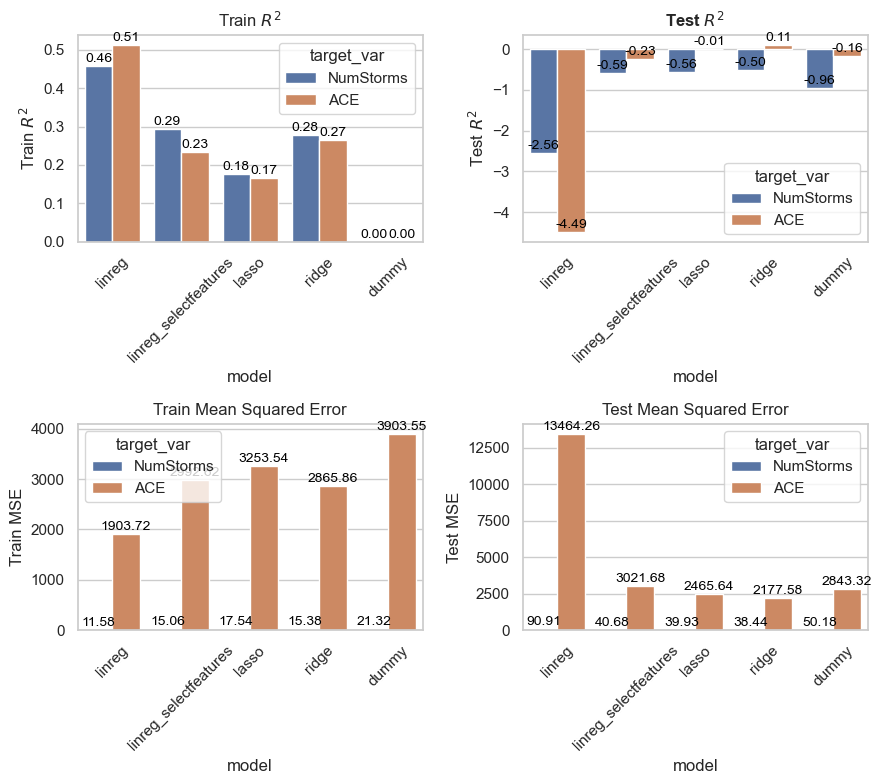

In [420]:
fig, ax = plt.subplots(2, 2, figsize=(9, 8)) 

# Function to add annotations
def add_annotations(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Train R2
sns.barplot(x='model', y='train r2', hue = 'target_var', data=results_all, ax=ax[0,0])
ax[0,0].set_title('Train $R^2$')
ax[0,0].set_ylabel('Train $R^2$')
add_annotations(ax[0,0])
#fig.gca().get_legend().set_title(None)
#ax[0,0].legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)

# Test R2
sns.barplot(x='model', y='test r2', hue = 'target_var', data=results_all, ax=ax[0,1])
ax[0,1].set_title('Test $R^2$', weight = 'bold')
ax[0,1].set_ylabel('Test $R^2$')
add_annotations(ax[0,1])

# Train MSE
sns.barplot(x='model', y='train mse', hue = 'target_var', data=results_all, ax=ax[1,0])
ax[1,0].set_title('Train Mean Squared Error')
ax[1,0].set_ylabel('Train MSE')
add_annotations(ax[1,0])

# Test MSE
sns.barplot(x='model', y='test mse', hue = 'target_var', data=results_all, ax=ax[1,1])
ax[1,1].set_title('Test Mean Squared Error')
ax[1,1].set_ylabel('Test MSE')
add_annotations(ax[1,1])

# Rotate x-axis labels by 45 degrees
for i in range(2):
    for j in range(2):
        ax[i, j].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('figures/results_MSE_R2.png')
plt.show()

Probably the most important statistic above is the negative test R^2, which could reveal one or more of the following issues:
- Not enough samples of data
- Data quality issues
- Not capturing the important features for hurricane prediction; or other inadequate feature engineering
- Over or underfitting
- Significant differences in behavior between the training and test data

### Inspecting Two Years where the Modeling Did and Did NOT predict well: 2014, 2020

What is happening in these years? Lets look at the ACE per Storm. Hypothesis is that the model is able to capture ACE per storm since this will be driven more directly by ocean temperatures (warm waters drive storm growth, but can't necessarily create a storm without other meteorological factors).

2020: Many storms, but water temperatures were not abnormally high heading into that season. ACE per storm was lower than average -- see below plot.

      NumStorms  ACE  ACE_per_storm
year                               
1976          8   84      10.500000
1977          6   25       4.166667
1978         11   63       5.727273
1979          8   93      11.625000
1980         11  149      13.545455


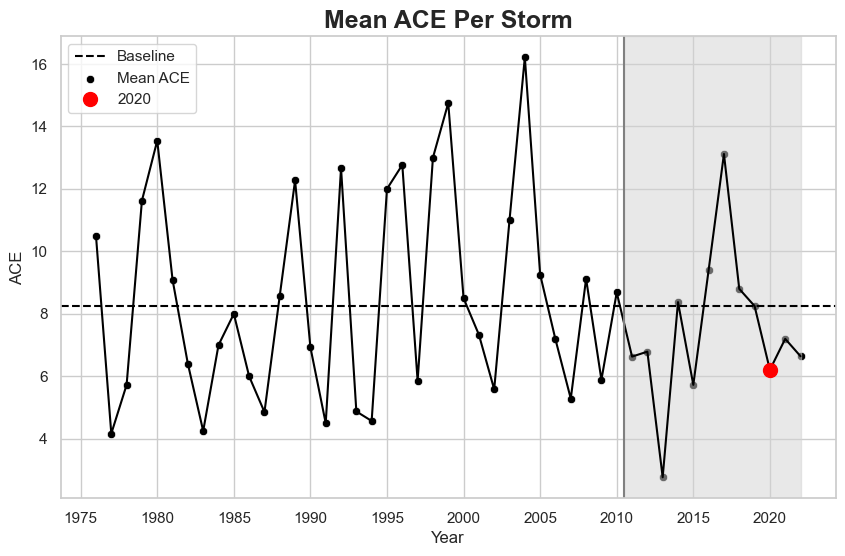

In [421]:
y_wACE['ACE_per_storm'] = y_wACE['ACE']/y_wACE['NumStorms']
avg_ace_per_storm = np.mean(y_wACE['ACE_per_storm'])
print(y_wACE.head())

plt.figure(figsize=(10, 6))
plt.axhline(y=avg_ace_per_storm, color='black', linestyle='--', label='Baseline')
sns.set(style='whitegrid')

# Plot Mean ACE per Storm
sns.scatterplot(data=y_wACE, x='year', y='ACE_per_storm', color='black', label='Mean ACE')
sns.lineplot(data=y_wACE, x='year', y='ACE_per_storm', color='black')

# Circle the year 2020
plt.plot(2020, y_wACE[y_wACE.index==2020]['ACE_per_storm'].values[0], 'o', color = 'red', markersize = 10, label = '2020')

# Formatting
plt.axvline(x=train_test_year_split+0.5, color='gray', linestyle='-')
max_year = np.max(y_wACE.index).astype(int)
plt.axvspan(train_test_year_split+0.5, max_year, color='lightgray', alpha=0.5)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('ACE')
plt.title('Mean ACE Per Storm', weight = 'bold', size = 18)
plt.legend()

# Customize the ticks and gridlines
from matplotlib.ticker import MultipleLocator
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.show()

    year  month  SouthHatteras_WDIR  SouthHatteras_WSPD  SouthHatteras_WVHT  \
4   2011      5          165.493802            4.497934            1.213970   
17  2012      5          164.363905            7.489053            1.826138   
32  2013      5          162.583673            6.680868            1.608681   
45  2014      5          184.416667            5.425461            1.211654   
60  2015      5          145.756793            6.871854            1.576802   

    SouthHatteras_PRES  SouthHatteras_ATMP  SouthHatteras_WTMP  MidGulf_WDIR  \
4          1073.733608           23.475826           24.979412    148.854054   
17         1014.568343           24.202071           25.359687    122.410014   
32         1092.979512           22.115940           23.238546    142.485792   
45         1020.709963           23.447417           25.236347    142.485792   
60         1021.136401           22.233018           22.848038    105.127371   

    MidGulf_WSPD  MidGulf_WVHT  MidGulf_PRES

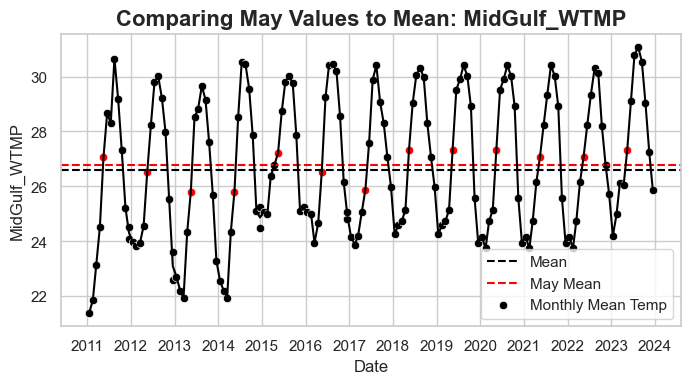

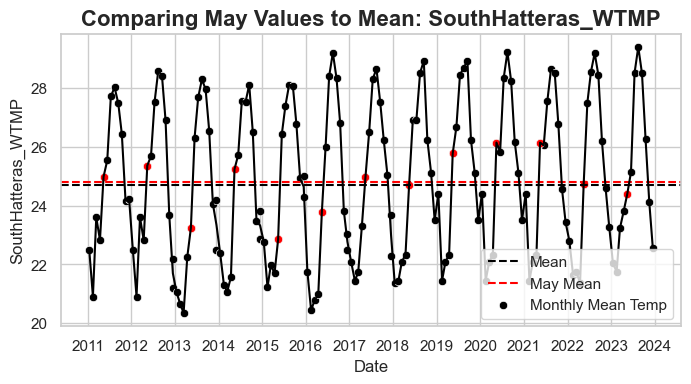

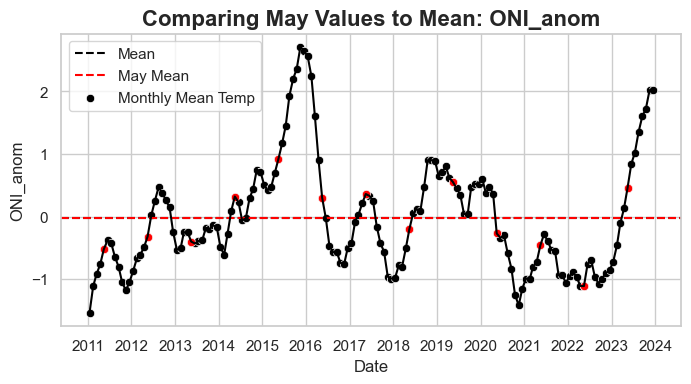

In [422]:
import matplotlib.dates as mdates
var_to_plot = 'MidGulf_WTMP'

buoy_data_subset = buoy_data_wide[buoy_data_wide['year']>2010]
buoy_data_subset = pd.merge(buoy_data_subset, oni[['year','month','ONI_anom']], on = ['year','month'], how = 'left')
buoy_data_subset['date'] = pd.to_datetime(buoy_data_subset[['year','month']].assign(day=15))
buoy_data_subset_may = buoy_data_subset[buoy_data_subset['month']==5]
print(buoy_data_subset_may.head())

for var_to_plot in ['MidGulf_WTMP','SouthHatteras_WTMP', 'ONI_anom']:
    
    mean_val = np.mean(buoy_data_subset[var_to_plot])
    may_mean_val = np.mean(buoy_data_subset_may[var_to_plot])
    
    plt.figure(figsize = (8,3.8))
    
    plt.axhline(y=mean_val, color='black', linestyle='--', label='Mean')
    plt.axhline(y=may_mean_val, color='red', linestyle='--', label='May Mean')
    sns.set(style='whitegrid')
    
    # Plot Mean ACE per Storm
    sns.scatterplot(data=buoy_data_subset, x='date', y=var_to_plot, color='black', label='Monthly Mean Temp')
    sns.lineplot(data=buoy_data_subset, x='date', y=var_to_plot, color='black')
    sns.scatterplot(data=buoy_data_subset_may, x='date', y=var_to_plot, color='red')

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel(var_to_plot)
    plt.title('Comparing May Values to Mean: '+var_to_plot, weight = 'bold', size = 16)
    plt.legend()

    # Set the x-axis major locator to YearLocator to have gridlines every year
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True, which='major', axis='x')  # Ensure gridlines are visible

    plt.savefig('figures/monthly_means_2011to2022_'+var_to_plot+'.png')
    plt.show()

## Most Important Features

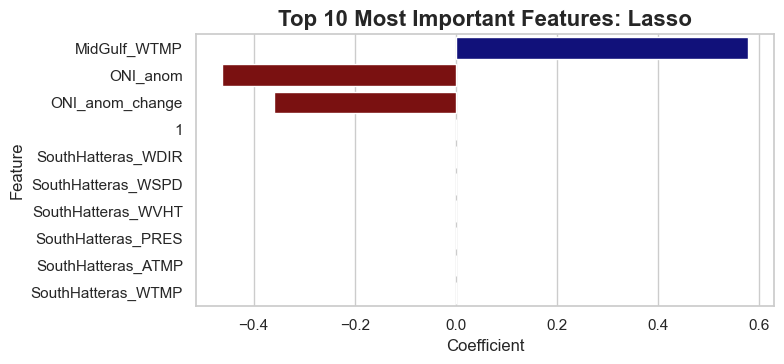

In [434]:
coefs_lasso_top10 = coefs_lasso.sort_values(by = 'coef', ascending = False, key = abs).head(10)

colors = coefs_lasso_top10['coef'].apply(lambda x: 'darkblue' if x > 0 else 'darkred')

plt.figure(figsize=(8, 3.8))
sns.barplot(x='coef', y='feature', data=coefs_lasso_top10, palette=colors)
plt.title('Top 10 Most Important Features: Lasso', weight = 'bold', size = 16)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('figures/results_important_features_Lasso.png')
plt.show()

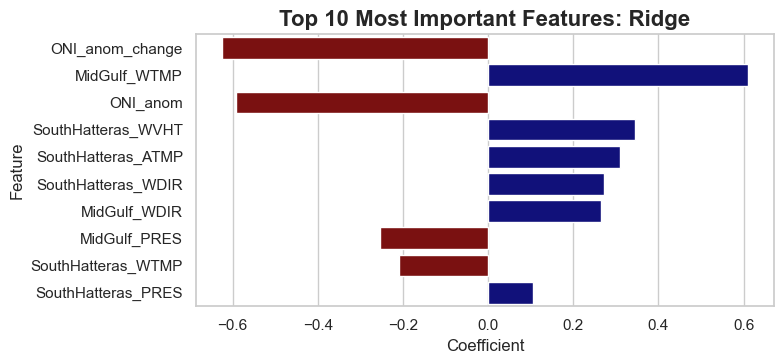

In [433]:
coefs_ridge_top10 = coefs_ridge.sort_values(by = 'coef', ascending = False, key = abs).head(10)
colors = coefs_ridge_top10['coef'].apply(lambda x: 'darkblue' if x > 0 else 'darkred')
plt.figure(figsize=(8,3.8))
sns.barplot(x='coef', y='feature', data=coefs_ridge_top10, palette = colors)
plt.title('Top 10 Most Important Features: Ridge', weight = 'bold', size = 16)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('figures/results_important_features_Ridge.png')
plt.show()

Magnitude of coefficient implies importance; sign (positive or negative) implies whether the feature is positively or negatively correlated with storm activity.